# Universidad del Valle de Guatemala
## Security Data Science - 10
* Walter Danilo Saldaña Salguero - 19897
* Javier Alejandro Cotto Argueta - 19324

## Laboratorio 5: Análisis de tráfico, implementación de un IDS

Importamos librearias

In [73]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import matplotlib.pyplot as plt
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

## Parte 1: Análisis Estadístico

Captura de 10 paquetes

In [4]:
num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print("El tipo de dato es:", type(pcap), "\n")
print("La longitud de los paquetes es:", len(pcap), "\n")
print("Contenido del pcap", pcap, "\n")
#pcap[0]

El tipo de dato es: <class 'scapy.plist.PacketList'> 

La longitud de los paquetes es: 10 

Contenido del pcap <Sniffed: TCP:4 UDP:2 ICMP:0 Other:4> 



Leemos el archivo "analisis_paquetes.pcap"

In [7]:
a = rdpcap("./analisis_paquetes.pcap")
a

<analisis_paquetes.pcap: TCP:0 UDP:62 ICMP:0 Other:0>

Añadimos los 10 paquetes al archivo de analisis

In [8]:
b = wrpcap("./analisis_paquetes.pcap", pcap, append=True)

In [9]:
b = rdpcap("./analisis_paquetes.pcap")
b

<analisis_paquetes.pcap: TCP:4 UDP:64 ICMP:0 Other:4>

Convertimos el pcap a un Dataframe

In [31]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in b[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.sample(5))

   version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
37       4   5  32    84   3259          0  122    17   3961  ...    None   
17       4   5  32    84  63672          0  122    17   9083  ...    None   
20       4   5   0  1051      1          0   64    17  21132  ...    None   
34       4   5   0  1004      1          0   64    17  21179  ...    None   
22       4   5   0    65  52414          0   64    17    802  ...    None   

   reserved flags window chksum urgptr options payload  \
37     None  None   None  65078   None    None      56   
17     None  None   None  65070   None    None      56   
20     None  None   None  51210   None    None    1023   
34     None  None   None  13507   None    None     976   
22     None  None   None     59   None    None      37   

                                          payload_raw  \
37  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...   
17  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...   
20  b'\x00\x0c\x0

Valores de las Columnas Src Addres, Dst Address, Src Port, Dst Port

In [33]:
df.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

In [38]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53
...,...,...,...,...
61,84.54.22.33,10.1.10.53,53,53
62,18.211.21.156,192.168.1.8,443,52512
63,192.168.1.8,18.211.21.156,52512,443
64,192.168.1.8,140.82.114.26,52743,443


### Estadisticas

a. Muestre cual es la IP origen más frecuente

In [48]:
frequent_or_address = df['src'].describe()['top']
print("La IP origen más frecuente es:", frequent_address)

La IP origen más frecuente es: 10.1.10.53


b. Muestre cual es la IP destino más frecuente

In [49]:
frequent_dest_address = df['dst'].describe()['top']
print("La IP destino más frecuente es:", frequent_address)

La IP destino más frecuente es: 10.1.10.53


c. ¿A qué IPs se comunica la IP del inciso a?

In [50]:
print("La IP origen más frecuente se comunica con:\n", df[df['src'] == frequent_or_address]['dst'].unique())

La IP origen más frecuente se comunica con:
 ['84.54.22.33' '75.75.75.75']


d. ¿A qué puertos destino se comunica la IP del inciso a?

In [51]:
print("La IP origen más frecuente se comunica con los puertos:\n", df[df['src'] == frequent_or_address]['dport'].unique())

La IP origen más frecuente se comunica con los puertos:
 [53]


e. ¿A qué puertos origen se comunica la IP del inciso b?

In [52]:
print("La IP destino más frecuente se comunica con los puertos:\n", df[df['sport'] == frequent_dest_address]['dst'].unique())

La IP destino más frecuente se comunica con los puertos:
 []


f. Indique el propósito de los puertos que más aparece en los incisos d y e

El proposito del puerto 53 es el protocolo que permite utilizar tanto TCP y UDP para la comunicación con servicios DNS.

### Gráficas

a. Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads
enviados de dichas direcciones.

IPS: ['10.1.10.53' '84.54.22.33' '75.75.75.75' '18.211.21.156' '192.168.1.8'
 '140.82.114.26']
Cantidad de Payloads [28053, 1624, 166, 6, 1, 0]


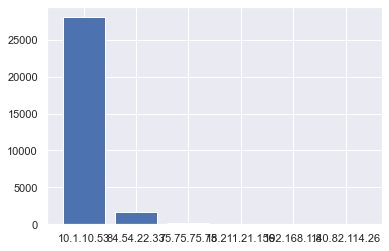

In [76]:
q_pay = []

for unique_ip in df.src.unique():
    pay = 0
    for index, ip in enumerate(df.src):
        if unique_ip == ip:
            pay += df.payload[index]
            
    q_pay.append(pay)

#IP y sus Payloads
print("IPS:", df["src"].unique())
print("Cantidad de Payloads", q_pay)

#Con la primer IP
plt.bar(df["src"].unique(), q_pay)
plt.show()

b. Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads
recibidos en dichas direcciones.

IPS: ['84.54.22.33' '10.1.10.53' '75.75.75.75' '192.168.1.8' '18.211.21.156'
 '140.82.114.26']
Cantidad de Payloads [27979, 1790, 74, 6, 0, 1]


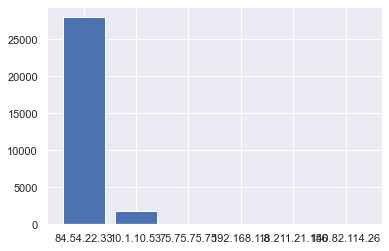

In [82]:
q_pay = []

for unique_ip in df.dst.unique():
    pay = 0
    for index, ip in enumerate(df.dst):
        if unique_ip == ip:
            pay += df.payload[index]
            
    q_pay.append(pay)

#IP y sus Payloads
print("IPS:", df["dst"].unique())
print("Cantidad de Payloads", q_pay)

#Con la primer IP
plt.bar(df["dst"].unique(), q_pay)
plt.show()

c. Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los
payloads enviados de dichos puertos.

PUERTOS: ['53', '15812', '23903', '443', '52512', '52743']
Cantidad de Payloads [29769, 37, 37, 6, 0, 1]


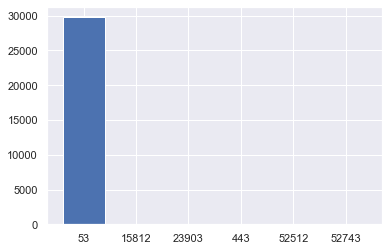

In [91]:
ports = []
q_pay = []

for unique_port in df.sport.unique():
    pay = 0
    ports.append(str(unique_port))
    for index, ip in enumerate(df.sport):
        if unique_port == ip:
            pay += df.payload[index]
            
    q_pay.append(pay)

#IP y sus Payloads
print("PUERTOS:", ports)
print("Cantidad de Payloads", q_pay)

plt.bar(ports, q_pay)
plt.show()

d. Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los
payloads recibidos en dichos puertos.

PUERTOS: ['53', '15812', '23903', '52512', '443', '52743']
Cantidad de Payloads [29677, 77, 89, 6, 1, 0]


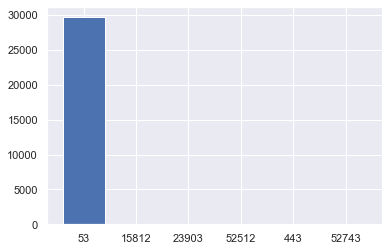

In [92]:
ports = []
q_pay = []

for unique_port in df.dport.unique():
    pay = 0
    ports.append(str(unique_port))
    for index, ip in enumerate(df.dport):
        if unique_port == ip:
            pay += df.payload[index]
            
    q_pay.append(pay)

#IP y sus Payloads
print("PUERTOS:", ports)
print("Cantidad de Payloads", q_pay)

plt.bar(ports, q_pay)
plt.show()

### Investigación de Payloads

Creamos un dataframe con la IP origen más frecuentada

In [98]:
df_new = df[df.src.isin(['10.1.10.53'])]
df_new

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
10,4,5,0,1045,1,,0,64,17,21138,...,None,None,None,None,5707,None,None,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
12,4,5,0,1008,1,,0,64,17,21175,...,None,None,None,None,31270,None,None,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
14,4,5,0,979,1,,0,64,17,21204,...,None,None,None,None,11600,None,None,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
16,4,5,0,959,1,,0,64,17,21224,...,None,None,None,None,7922,None,None,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
18,4,5,0,992,1,,0,64,17,21191,...,None,None,None,None,22145,None,None,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


Creamos un dataframe con las columnas Src Addres, Dst Addres y agrupamos por payload

In [139]:
df_new2 = df_new[["src", "dst", "payload"]]
df_new2 = df_new2.reset_index()
df_new2.sample(5)

,index,src,dst,payload
23,46,10.1.10.53,84.54.22.33,978
15,30,10.1.10.53,84.54.22.33,976
4,8,10.1.10.53,84.54.22.33,975
29,58,10.1.10.53,84.54.22.33,941
11,22,10.1.10.53,75.75.75.75,37


Obtener la IP que ha realizado más operaciones con la IP origen más frecuente

In [140]:
q_pay = []
ip_quantity = {}

for unique_ip in df_new2.src.unique():
    pay = 0
    for index, ip in enumerate(df_new2.dst):
        if unique_ip == '10.1.10.53':
            pay += df_new2.payload[index]
            ip_quantity[ip] = pay

print(ip_quantity)

{'84.54.22.33': 28053, '75.75.75.75': 10749}


La ip más sospechosa es: 84.54.22.33 con un total de 28053 conexiones con la IP origen más frecuente.

Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.

In [147]:
df_new3 = df_new.loc[df_new["dst"] == '84.54.22.33']
df_new3.sample(5)

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
42,4,5,0,1010,1,,0,64,17,21173,...,None,None,None,None,45536,None,None,982,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
28,4,5,0,986,1,,0,64,17,21197,...,None,None,None,None,16099,None,None,958,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
32,4,5,0,1037,1,,0,64,17,21146,...,None,None,None,None,14360,None,None,1009,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


Obtenga los payloads del DF del inciso 6, y añada cada uno en un array.

In [ ]:
f. Muestre el contenido del array.
g. Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido
que se envié a través del puerto explicado en el inciso f?